# Mapa de Coropletas Bivariable

Por [**Eduardo Graells-Garrido** (@carnby)](https://twitter.com/carnby), <eduardo.graells@bsc.es>

**Objetivo**: realizar un mapa de coropletas donde cada área de interés se grafique con un color que codifique la mezcla de dos variables. Lo haremos en el área urbana de Santiago, utilizando como variables la tasa de migración y el nivel educacional.

**Datos**: 
Los microdatos del [Censo 2017](http://www.censo2017.cl/) se pueden obtener visitando las oficinas del Instituto Nacional de Estadísticas y pedirlos en un DVD. O bien los puedes bajar desde [Google Drive](https://drive.google.com/drive/u/1/folders/12qIuycAHmXPDwqmtz4PB_ozfj1Wd9Zjn) cortesía del [Centro de Investigación del Arvo Shanpion](https://mobile.twitter.com/CIAS_Chile).

**Nota**: se utilizan algunos conceptos y datos que se generan en los otros notebooks de este repositorio. 

### Preámbulo

In [1]:
# para cargar shapefiles y graficarlos
import geopandas as gpd
# para cargar los datos del censo y procesarlos
import dask.dataframe as dd
# para trabajar con vectores de números y operaciones sobre ellos
import numpy as np
# para ejecutar operaciones entre colores
import spectra
# para segmentar las variables en categorías
import mapclassify
# para ejecutar operaciones entre elementos geográficos
import shapely
# para escribir en un gráfico con letras delineadas
import matplotlib.patheffects as path_effects
# para operar con colores en cada gráfico
from matplotlib.colors import rgb2hex
# lo usual de matplotlib y seaborn
import matplotlib.pyplot as plt
import seaborn as sns
# configuraciones
%matplotlib inline
%config InlineBackend.figure_format='retina'
# si no tienes instalada esta fuente, saca este parámetro
sns.set(style='ticks', font='Fira Sans Extra Condensed', context='notebook', palette='viridis')

### Carguemos los Datos del Área Urbana de Santiago

Nota: En el notebook _Datos Censales a Nivel Individual_ expongo como funciona `dask.dataframe`.

In [2]:
census = dd.read_csv('./input/Microdato_Censo2017-Personas.csv', sep=';')
census.head()

,REGION,PROVINCIA,COMUNA,DC,AREA,ZC_LOC,ID_ZONA_LOC,NVIV,NHOGAR,PERSONAN,...,P18,P19,P20,P21M,P21A,P10PAIS_GRUPO,P11PAIS_GRUPO,P12PAIS_GRUPO,ESCOLARIDAD,P16A_GRUPO
0,15,152,15202,1,2,6,13225,1,1,1,...,98,98,98,98,9998,998,998,998,4,2
1,15,152,15202,1,2,6,13225,3,1,1,...,98,98,98,98,9998,998,998,998,0,2
2,15,152,15202,1,2,6,13225,3,1,2,...,98,1,1,3,1965,998,998,998,0,2
3,15,152,15202,1,2,6,13225,3,1,3,...,98,2,1,4,1995,998,998,998,2,2
4,15,152,15202,1,2,6,13225,3,1,4,...,Z,98,98,98,9998,998,998,998,3,2


In [3]:
rm = census[census.REGION == 13].compute()
rm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7112808 entries, 114000 to 332590
Data columns (total 42 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   REGION         int64 
 1   PROVINCIA      int64 
 2   COMUNA         int64 
 3   DC             int64 
 4   AREA           int64 
 5   ZC_LOC         int64 
 6   ID_ZONA_LOC    int64 
 7   NVIV           int64 
 8   NHOGAR         int64 
 9   PERSONAN       int64 
 10  P07            int64 
 11  P08            int64 
 12  P09            int64 
 13  P10            int64 
 14  P10COMUNA      int64 
 15  P10PAIS        int64 
 16  P11            int64 
 17  P11COMUNA      int64 
 18  P11PAIS        int64 
 19  P12            int64 
 20  P12COMUNA      int64 
 21  P12PAIS        int64 
 22  P12A_LLEGADA   int64 
 23  P12A_TRAMO     int64 
 24  P13            int64 
 25  P14            int64 
 26  P15            int64 
 27  P15A           int64 
 28  P16            int64 
 29  P16A           int64 
 30  P16A_OTRO     

In [4]:
rm['is_migrant'] = rm.P12PAIS < 998
rm['is_migrant'].value_counts()

False    6887041
True      225767
Name: is_migrant, dtype: int64

Con esto calculamos las variables que nos interesan:

* `migrants`: cantidad de migrantes en un distrito censal.
* `population`: población en un distrito censal.
* `education_level`: escolaridad promedio en un distrito censal. **Nota**: el promedio de esta variable se usa como ejemplo. Pero en un análisis real habría que tener muchas consideraciones, como que esta variable puede estar condicionada por la edad de una persona. Por eso, para evitar malinterpretaciones, estudiaremos solamente población **de 25 o más años**.

In [5]:
dc_stats = rm[rm.P09 >= 25].groupby(['REGION', 'PROVINCIA', 'COMUNA', 'DC']).agg(migrants=('is_migrant', 'sum'), population=('is_migrant', 'size'), education_level=('ESCOLARIDAD', 'mean'))

In [6]:
dc_stats.describe()

,migrants,population,education_level
count,503.000000,503.000000,503.000000
mean,338.075547,9237.449304,14.006355
std,640.788379,8031.467671,2.341212
min,0.000000,9.000000,7.891089
25%,49.000000,3366.000000,12.529467
50%,141.000000,8426.000000,13.552226
75%,324.000000,12064.000000,14.984795
max,6580.000000,59547.000000,30.384615


### Datos Geográficos

Cargamos los mapas que generamos en _Mapas por Distrito Censal_, que contienen los distritos censales y comunas del área urbana de Santiago.

In [7]:
stgo = gpd.read_file('output/stgo_urban_districts.shp')
stgo.head()

,REGION,PROVINCIA,COMUNA,COD_DISTRI,DESC_REGIO,DESC_PROVI,DESC_COMUN,DESC_DISTR,geometry
0,13,131,13114,4,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,LAS CONDES,"POLYGON ((-70.47777 -33.36495, -70.48101 -33.3..."
1,13,131,13114,15,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,SAN CARLOS DE APOQUINDO,"POLYGON ((-70.49790 -33.38026, -70.49823 -33.3..."
2,13,131,13114,16,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,CERRO CALÁN,"POLYGON ((-70.50789 -33.38245, -70.50774 -33.3..."
3,13,131,13114,2,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,ESTADIO PALESTINO,"POLYGON ((-70.53606 -33.38529, -70.53652 -33.3..."
4,13,131,13114,3,REGIÓN METROPOLITANA DE SANTIAGO,SANTIAGO,LAS CONDES,HOSPITAL FACH,"POLYGON ((-70.54504 -33.39658, -70.54575 -33.3..."


Con esta operación cruzamos (`join`) la información geográfica con las estadísticas que calculamos. **Nota**: los nombres de las columnas no eran los mismos, así que es necesario corregirlo con la función `rename`.

In [8]:
stgo_stats = (stgo.rename({'COD_DISTRI': 'DC'}, axis='columns')
              .set_index(['REGION', 'PROVINCIA', 'COMUNA', 'DC'])
              .join(dc_stats))
stgo_stats.head()

DESC_REGIO DESC_PROVI  \
REGION PROVINCIA COMUNA DC                                                
13     131       13114  4   REGIÓN METROPOLITANA DE SANTIAGO   SANTIAGO   
                        15  REGIÓN METROPOLITANA DE SANTIAGO   SANTIAGO   
                        16  REGIÓN METROPOLITANA DE SANTIAGO   SANTIAGO   
                        2   REGIÓN METROPOLITANA DE SANTIAGO   SANTIAGO   
                        3   REGIÓN METROPOLITANA DE SANTIAGO   SANTIAGO   

                            DESC_COMUN               DESC_DISTR  \
REGION PROVINCIA COMUNA DC                                        
13     131       13114  4   LAS CONDES               LAS CONDES   
                        15  LAS CONDES  SAN CARLOS DE APOQUINDO   
                        16  LAS CONDES              CERRO CALÁN   
                        2   LAS CONDES        ESTADIO PALESTINO   
                        3   LAS CONDES            HOSPITAL FACH   

                                                                     geometry  \
REGION PROVINCIA COMUNA DC                                                      
13     131       13114  4   POLYGON ((-70.47777 -33.36495, -70.48101 -33.3...   
                        15  POLYGON ((-70.49790 -33.38026, -70.49823 -33.3...   
                        16  POLYGON ((-70.50789 -33.38245, -70.50774 -33.3...   
                        2   POLYGON ((-70.53606 -33.38529, -70.53652 -33.3...   
                        3   POLYGON ((-70.54504 -33.39658, -70.54575 -33.3...   

                            migrants  population  education_level  
REGION PROVINCIA COMUNA DC                                         
13     131       13114  4      636.0       10770        17.349025  
                        15     541.0        9704        16.886645  
                        16     505.0        9647        16.609620  
                        2      839.0       10318        17.050300  
                        3     1514.0       14529        18.414275

Calculemos la tasa de migrantes:

In [9]:
stgo_stats['migrant_rate'] = stgo_stats['migrants'] / stgo_stats['population']

Graficamos la tasa de migrantes utilizando cuatro categorías y la segmentación Fisher Jenks:

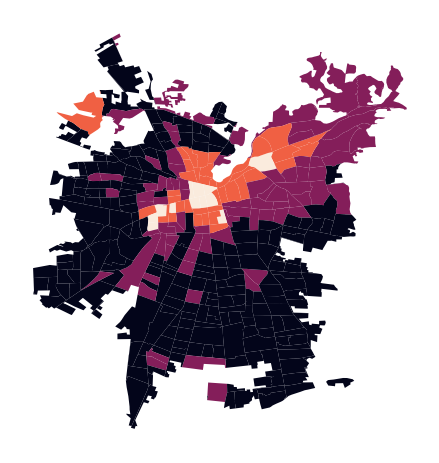

In [10]:
ax = stgo_stats.plot(column='migrant_rate', edgecolor='none', scheme='fisherjenks', k=4)
ax.set_axis_off()

Graficamos el nivel educacional promedio utilizando cuatro categorías y la segmentación Fisher Jenks:

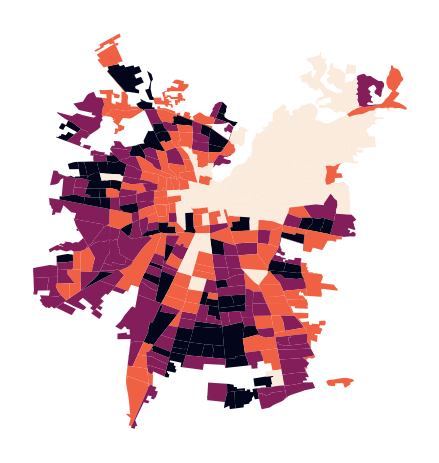

In [11]:
ax = stgo_stats.plot(column='education_level', edgecolor='none', scheme='fisherjenks', k=4)
ax.set_axis_off()

No he mostrado la escala en ambos gráficos, porque el propósito es ejemplificar que el objetivo de este notebook es mostrar la relación de ambas variables en un único mapa.

## Ya tenemos las variables. Siguiente paso: elegir una paleta de colores

Por simplicidad usaremos una paleta divergente, pero aquí puedes hacer volar tu imaginación y combinar dos paletas distintas secuenciales.

Necesitamos elegir **la cantidad de categorías**. En genera, este tipo de mapas usa **3** categorías, pero solo porque podemos usar más, elegiremos **4**. El código que resta después es independiente a la cantidad elegida, por tanto, queda como propuesto experimentar ;)

In [12]:
n_categories = 4

Creamos la paleta divergente:

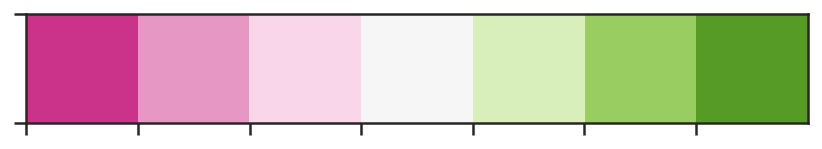

In [14]:
full_palette = sns.color_palette('PiYG', n_colors=(n_categories - 1) * 2 + 1)
sns.palplot(full_palette)

Ahora la dividiremos en dos. Lo hacemos así porque aseguramos que el color inicial de cada paleta es el mismo. Si usas dos paletas distintas, tienes que realizar ese ajuste por tu cuenta.

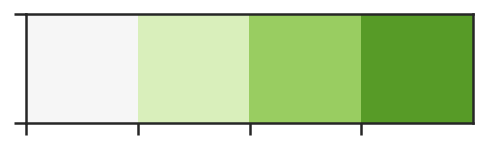

In [15]:
cmap_x = full_palette[n_categories - 1:]
sns.palplot(cmap_x)

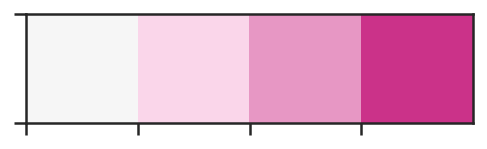

In [16]:
cmap_y = list(reversed(full_palette))[n_categories - 1:]
sns.palplot(cmap_y)

#### Categorizando la primera variable

Utilizamos el algoritmo de Fisher Jenks para asignarle una categoría a cada área que visualizaremos. El resultado nos dice los rangos de valores de cada categoría:

In [18]:
migrant_rate_bin = mapclassify.FisherJenks(stgo_stats['migrant_rate'], k=n_categories)
migrant_rate_bin

FisherJenks         

  Interval     Count
--------------------
[0.00, 0.03] |   215
(0.03, 0.08] |    78
(0.08, 0.15] |    37
(0.15, 0.34] |    12

Esto se ve así. Aquí usamos `numpy` (`np`) porque necesitamos dibujar semi-manualmente cada categoría, con el fin de explicitar el color que queremos utilizar.

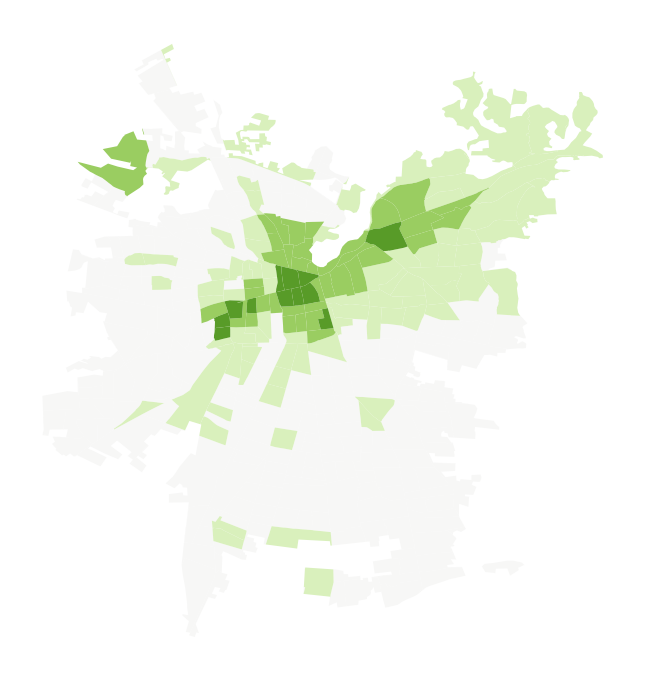

In [19]:
# creamos la figura
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# por cada categoría dibujamos en la figura
for i in range(n_categories):
    areas_in_this_category = np.where(migrant_rate_bin.yb == i)[0]
    # usamos el método rgb2hex para que matplotlib reconozca el color que utilizamos
    stgo_stats.iloc[areas_in_this_category].plot(color=rgb2hex(cmap_x[i]), ax=ax, edgecolor='none')
    
# sacamos elementos decorativos del gráfico
ax.set_axis_off()

#### Segunda variable: Nivel educacional promedio

Hacemos lo mismo para la siguiente variable.

In [20]:
education_level_bin = mapclassify.FisherJenks(stgo_stats['education_level'], k=n_categories)
education_level_bin

FisherJenks           

   Interval      Count
----------------------
[10.40, 12.62] |    71
(12.62, 13.96] |   109
(13.96, 15.73] |    92
(15.73, 18.52] |    70

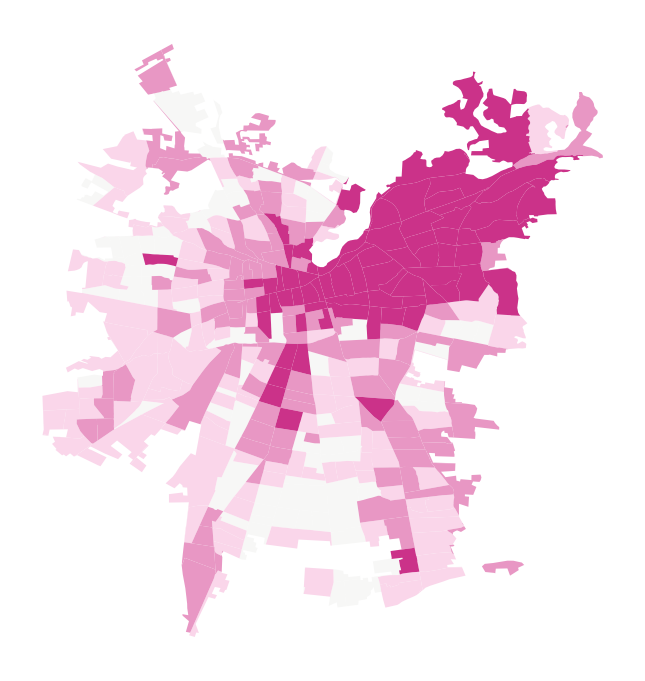

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(n_categories):
    areas_in_this_category = np.where(education_level_bin.yb == i)[0]
    stgo_stats.iloc[areas_in_this_category].plot(color=rgb2hex(cmap_y[i]), ax=ax, edgecolor='none')
    
ax.set_axis_off()

### Combinando las paletas de colores

Ya tenemos dos mapas, pero eso no se diferencia mucho de los mapas que graficamos inicialmente.

Lo que haremos en esta parte es hacer una paleta de colores _combinada_ que le asigna un color a todas las combinaciones posibles de categorías. Esta combinación debe respetar la secuencialidad que tiene cada paleta por separado, es decir, tener un color más intenso para valores más altos.

Para ello, utilizaremos la biblioteca [`spectra`](https://github.com/jsvine/spectra), que se encarga de hacer este tipo de operaciones.

El siguiente código hace la combinación de las dos paletas. ¡Intenta entender lo que hace! Los resultados se almacenan (por conveniencia) en dos variables: `cmap_xy` y `bivariate_palette`.

In [24]:
cmap_xy = []
bivariate_palette = {}

for j in range(n_categories):
    for i in range(n_categories):
        x = spectra.rgb(*cmap_x[i][0:3])
        y = spectra.rgb(*cmap_y[j][0:3])
        
        if i == j and i == 0:
            cmap_xy.append(x.darken(1.5).rgb)
        elif i == 0:
            cmap_xy.append(y.rgb)
        elif j == 0:
            cmap_xy.append(x.rgb)
        else: 
            blended = x.blend(y, ratio=0.5)
            
            if i == j:
                blended = blended.saturate(7.5 * (i + 1))
            else:
                blended = blended.saturate(4.5 * (i + 1))
                
            cmap_xy.append(blended.rgb)
            
        bivariate_palette[(i, j)] = rgb2hex(cmap_xy[-1])
            
cmap_xy = np.array(cmap_xy).reshape(n_categories, n_categories, 3)

Esto es lo que contiene la variable `cmap_xy`:

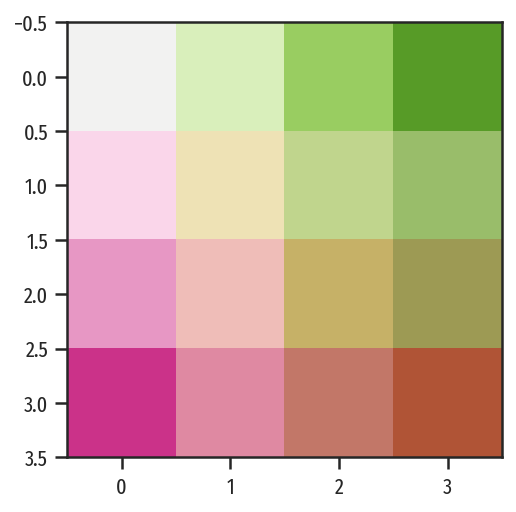

In [25]:
plt.imshow(cmap_xy)

Es una matriz que contiene todas las combinaciones posibles de categorías, y un color único para cada una.

Y esto es lo que contiene `bivariate_palette`:

In [26]:
bivariate_palette

{(0, 0): '#f2f3f2',
 (1, 0): '#d9f0bc',
 (2, 0): '#9acd61',
 (3, 0): '#589b28',
 (0, 1): '#fad6ea',
 (1, 1): '#efe3b6',
 (2, 1): '#c1d58d',
 (3, 1): '#9abe6a',
 (0, 2): '#e897c4',
 (1, 2): '#efbeb8',
 (2, 2): '#c6b268',
 (3, 2): '#9e9b55',
 (0, 3): '#cb3289',
 (1, 3): '#df89a3',
 (2, 3): '#c37768',
 (3, 3): '#b15537'}

Es la misma información, pero almacenada de manera más accesible por nuestro código y con colores que puede entender fácilmente matplotlib.

Veamos como se ve esto en un mapa:

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


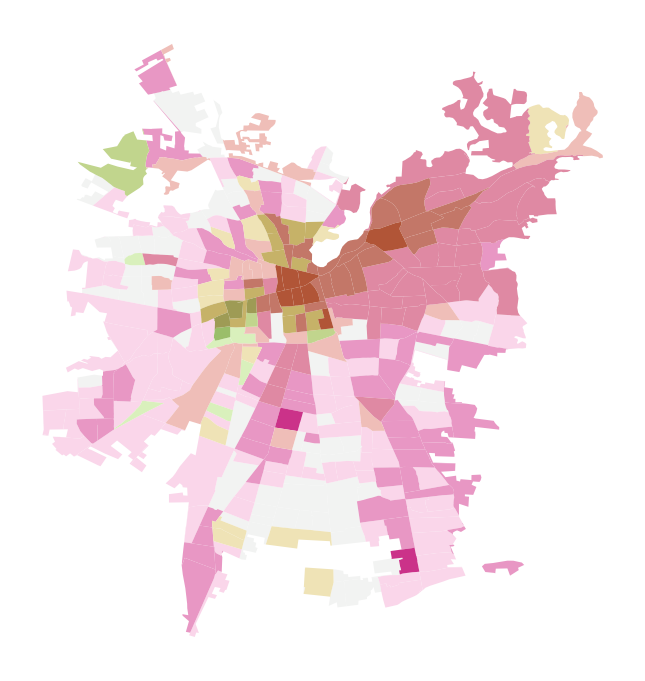

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for i in range(n_categories):
    for j in range(n_categories):
        areas_in_this_category = set(np.where(migrant_rate_bin.yb == i)[0]) & set(np.where(education_level_bin.yb == j)[0])
        stgo_stats.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(i, j)], ax=ax, edgecolor='none')
    
ax.set_axis_off()

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


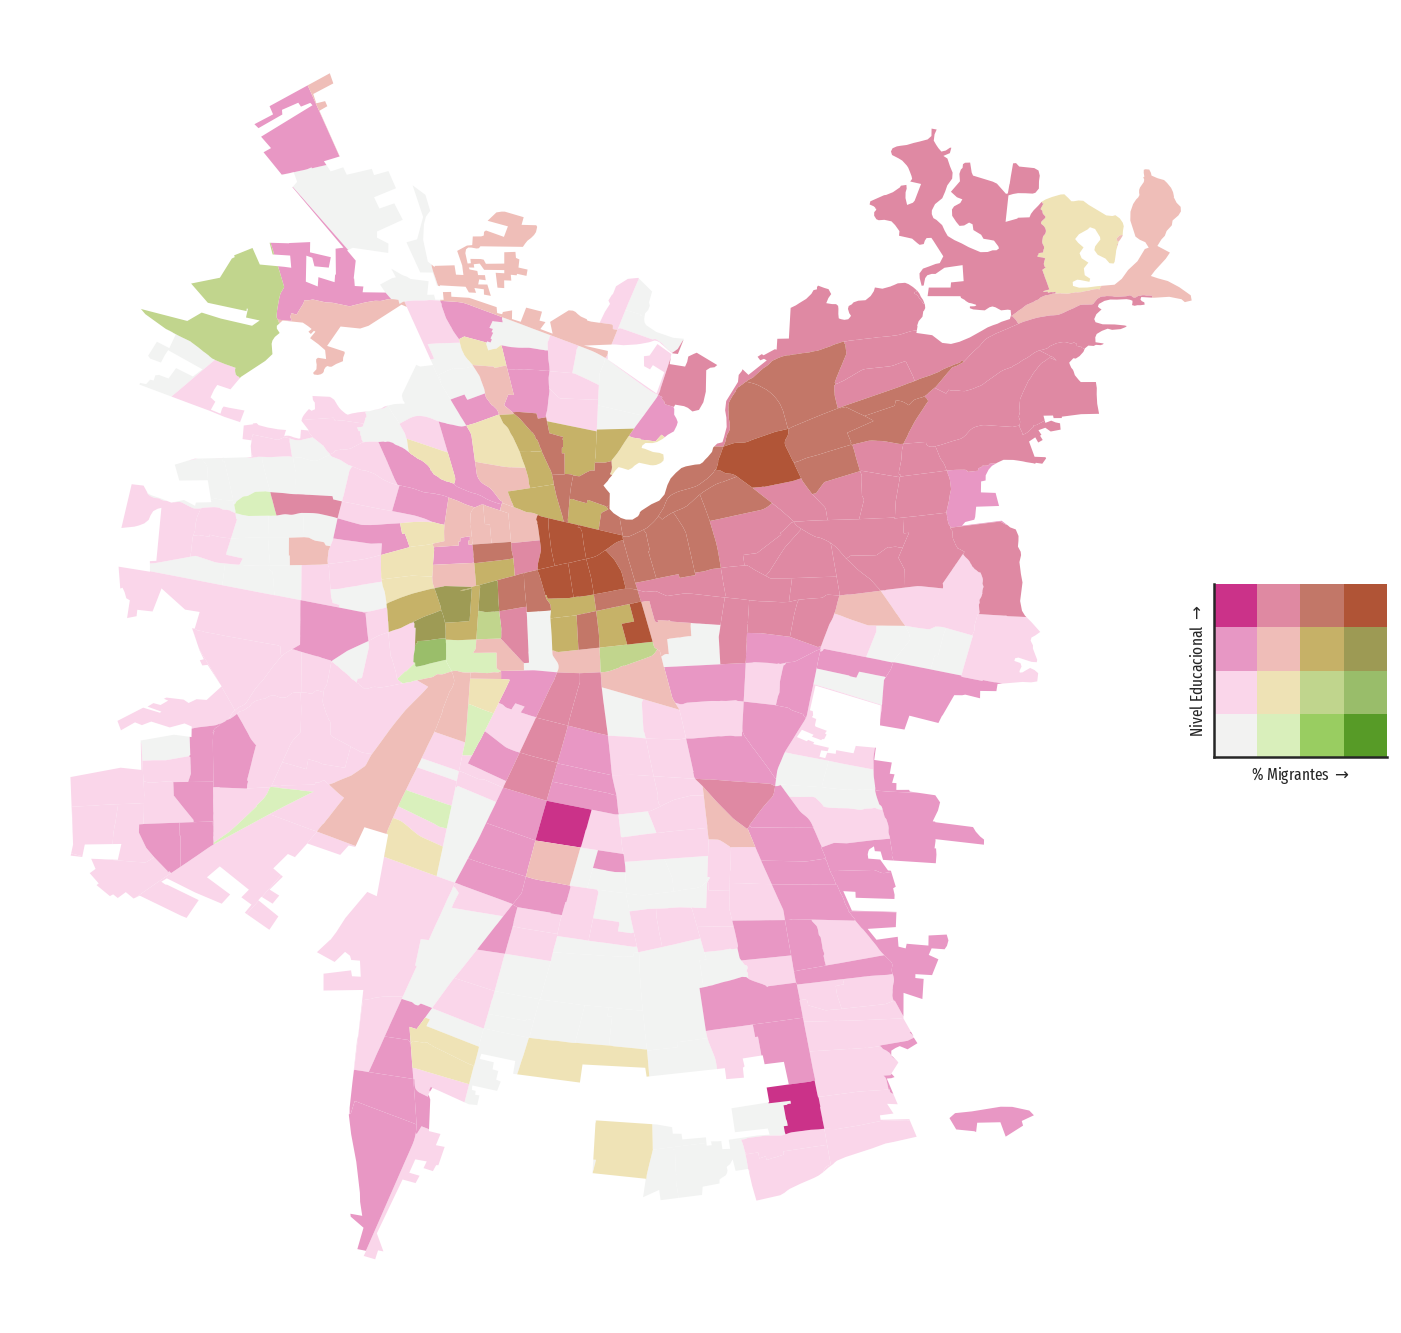

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for i in range(n_categories):
    for j in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        areas_in_this_category = set(np.where(migrant_rate_bin.yb == i)[0]) & set(np.where(education_level_bin.yb == j)[0])
        stgo_stats.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(i, j)], ax=ax, edgecolor='none')
    
ax.set_axis_off()

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.85, .45, .1, .1], facecolor='y')
a.imshow(cmap_xy, origin='lower')
a.set_xlabel('% Migrantes $\\rightarrow$', fontsize='x-small')
a.set_ylabel('Nivel Educacional $\\rightarrow$', fontsize='x-small')
a.set_xticks([])
a.set_yticks([])
sns.despine(ax=a)

### Añadiendo Información Contextual

Tal como en el notebook _Mapas por Distrito Censal_, aquí agregamos información contextual que permite explorar mejor el gráfico y el contexto político-administrativo. Para ello, cargaremos los bordes municipales que calculamos en ese notebook.

In [31]:
municipalities = gpd.read_file('output/stgo_urban_municipalities.shp')

Definimos los límites de nuestro gráfico. Esto es necesario porque los bordes comunales no coinciden con los bordes del área urbana.

In [32]:
bounds = stgo_stats.total_bounds
aspect = (bounds[2] - bounds[0]) / (bounds[3] - bounds[1])
box = shapely.geometry.box(*bounds)

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


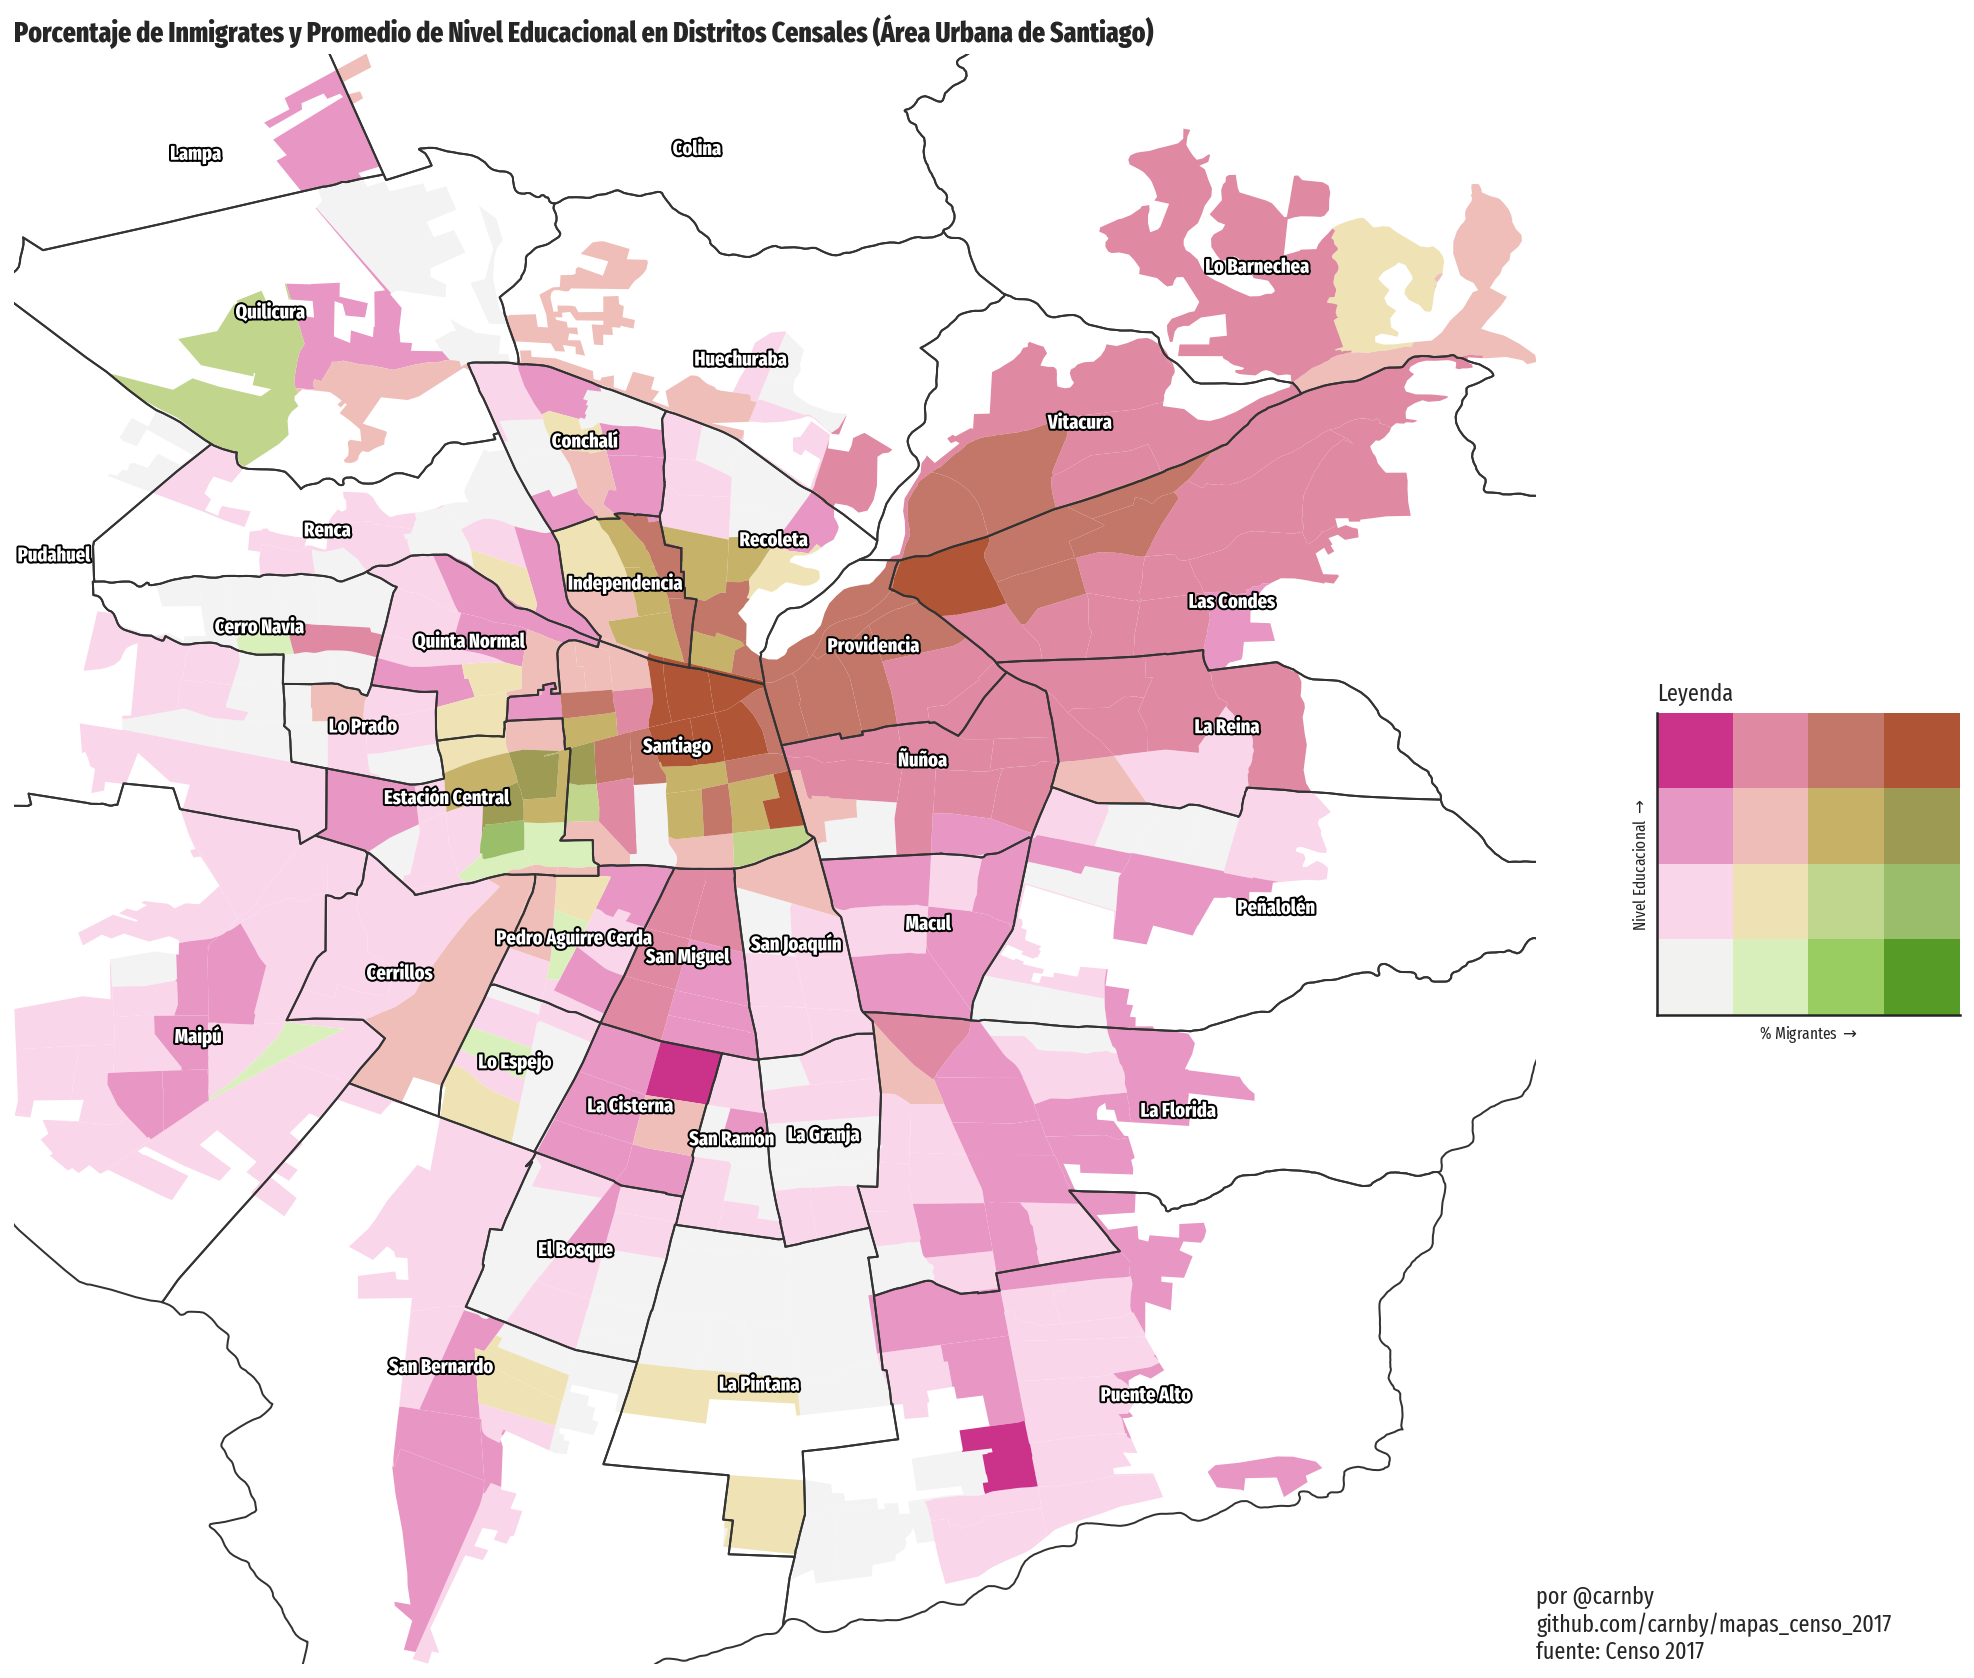

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14 / aspect))

# definimos los bordes manualmente, para que no se dibuje nada fuera de ellos
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

for i in range(n_categories):
    for j in range(n_categories):
        areas_in_this_category = set(np.where(migrant_rate_bin.yb == i)[0]) & set(np.where(education_level_bin.yb == j)[0])
        stgo_stats.iloc[list(areas_in_this_category)].plot(color=bivariate_palette[(i, j)], ax=ax, edgecolor='none')
    
ax.set_axis_off()

# agregamos los bordes municipales
municipalities.plot(facecolor='none', edgecolor='#333333', linewidth=1, ax=ax)

# agregamos el nombre de cada municipalidad
for idx, row in municipalities.set_index('NOM_COM').iterrows():
    centroid = row.geometry.intersection(box).representative_point()
    t = ax.text(centroid.x, centroid.y, idx, horizontalalignment='center', fontsize=10, fontweight='bold', color='white')
    t.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])


a = fig.add_axes([0.95, .425, .15, .15], facecolor='y')
a.imshow(cmap_xy, origin='lower')
a.set_xlabel('% Migrantes $\\rightarrow$', fontsize='x-small')
a.set_ylabel('Nivel Educacional $\\rightarrow$', fontsize='x-small')
a.set_xticks([])
a.set_yticks([])
a.set_title('Leyenda', loc='left')
sns.despine(ax=a)

# añadimos título y créditos
ax.set_title('Porcentaje de Inmigrates y Promedio de Nivel Educacional en Distritos Censales (Área Urbana de Santiago)', loc='left', 
            fontweight='bold', fontsize=14)
ax.annotate('por @carnby\ngithub.com/carnby/mapas_censo_2017\nfuente: Censo 2017', (1.0, 0.0), xycoords='axes fraction', fontsize=12, va='bottom')

# grabamos el resultado en un fichero png
plt.savefig('bivariate_choro.png', dpi=150, bbox_inches='tight');

¿Qué tal? Como ves, el trabajo más difícil lo realizan bibliotecas como `matplotlib`, `geopandas` y `spectra`. Lo necesario para ponerlas a trabajar juntas lo puedes encontrar en este notebook. Espero que te sea útil ;) 

-- @carnby